In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

---
# 1. 사진 준비
---

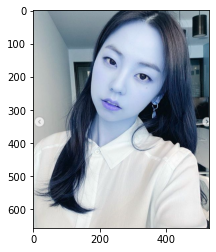

(656, 530, 3)


In [3]:
import os

# 고개를 옆으로 돌린 고양이상 소희 사진을 들고 왔다.
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/sohee_tilted.jpg'
img_bgr = cv2.imread(my_image_path) # open cv로 읽고
# img_bgr = cv2.resize(img_bgr, (1350*2, 1080*3)) # resize하면 찌그러져서 안했다.
img_show = img_bgr.copy() # 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()
print(img_bgr.shape)

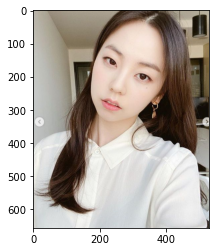

In [4]:
# bgr 에서 rgb로 바꿔서 푸르딩딩한 사진을 바꾸자
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

---
# 2. Face detection
dlib의 face detector는 HOG(Histogram of oriented Gradient) feature를 이용해서 svm의 sliding window로 얼굴을 찾는다.

---

In [5]:
import dlib
detector_hog = dlib.get_frontal_face_detector() # detector선언
print('--')

--


In [6]:
# bounding box
import cv2
dlib_rects=detector_hog(img_rgb,1)
print('--')

--


## 이미지 피라미드 
* detector_hog의 두번째 파라미터가 이미지 피라미드
* 동일 이미지의 서로 다른 사이즈의 세트
* 업샘플링으로 크기를 키우는 것
* 이미지 피라미드에서 얼굴 검출시 작게 촬영된 얼굴을 크게 볼 수 있어 더 정확한 검출이 가능

In [7]:
print(dlib_rects) #얼굴영역 좌표

rectangles[[(142, 118) (365, 341)]]


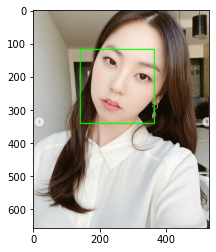

In [8]:
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()    
    r = dlib_rect.right()    
    b = dlib_rect.bottom()    
    cv2.rectangle(img_show,(l,t),(r,b),(0,255,0),2,lineType=cv2.LINE_AA)

img_show_rgb = cv2.cvtColor(img_show,cv2.COLOR_BGR2RGB)    
plt.imshow(img_show_rgb)
plt.show()
# 이쁘게 네모 박스로 얼굴이 잡혔다.

---
# 3. Face landmark
---

In [9]:
import os
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print('--')

--


In [10]:
list_landmarks=[]
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb,dlib_rect) # dlib.full_object_detection 반환
    list_points=list(map(lambda p:(p.x,p.y),points.parts()))
    list_landmarks.append(list_points)
print(len(list_landmarks[0])) #68개의 랜드마크가 얼굴 개수만큼 저장됨
print(list_landmarks[0][0])
print(list_landmarks)


68
(195, 124)
[[(195, 124), (185, 153), (179, 182), (174, 211), (173, 240), (177, 269), (185, 294), (196, 317), (213, 330), (236, 336), (264, 332), (292, 325), (316, 312), (338, 293), (357, 272), (377, 248), (393, 222), (210, 107), (227, 103), (246, 110), (261, 123), (273, 138), (311, 157), (334, 158), (355, 163), (373, 173), (384, 189), (279, 175), (270, 194), (261, 213), (252, 233), (232, 238), (237, 244), (244, 251), (255, 253), (266, 256), (216, 147), (230, 146), (244, 154), (251, 170), (237, 166), (223, 159), (309, 197), (326, 192), (340, 198), (350, 210), (336, 211), (321, 205), (206, 270), (219, 267), (231, 266), (238, 273), (248, 273), (259, 285), (267, 299), (250, 303), (236, 303), (226, 300), (217, 295), (210, 286), (211, 273), (227, 279), (234, 283), (244, 285), (261, 296), (242, 288), (232, 285), (225, 281)]]


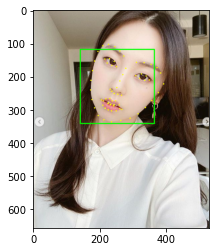

In [11]:
# 랜드마크 영상에 출력하기
for landmark in list_landmarks:
    for idx,point in enumerate(list_points):
        cv2.circle(img_show,point,2,(0,255,255),-1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()
# 너무 작아서 안보이는데 랜드마크 잡힌거 맞다.

---
# 4. 스티커 적용하기
---

1. landmark위치 
- landmark 위치 2,36,48,30번 인덱스 사용  

top-left 이미지 시작점 지정
- x: 30번 위치에서 - 수염 이미지의 가로 길이 절반 
- y: 30번 위치에서 - 수염 이미지의 세로 길이 절반

2. sticker크기  
length = dlib_rect.width()  
width = length  
height = length
그대로 적용

In [12]:
for dlib_rect,landmark in zip(dlib_rects,list_landmarks):
    print(landmark[30]) # nose center index :30
    x = landmark[30][0] 
    y = landmark[30][1] 
    w = dlib_rect.width() 
    h = dlib_rect.width()
    print('(x,y):(%d,%d)'%(x,y)) # 30번 코 중심점 좌표
    print('(w,h):(%d,%d)'%(w,h))

(252, 233)
(x,y):(252,233)
(w,h):(224,224)


In [13]:
import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat_whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker,(w,h))
print(img_sticker.shape)

# whiskers = cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB)
# plt.imshow(whiskers)
# plt.show()

(224, 224, 3)


In [14]:
# 원본 이미지에 스티커 이미지 추가하기 위해 x,y 좌표 조정
# 이미지 시작점은 top-left. 
refined_x = x - w//2 # left
refined_y = y - h//2 # top
print('(x,y):(%d,%d)'%(refined_x,refined_y))


(x,y):(140,121)


In [20]:
# y 좌표 음수 처리. 이미지 범위 밖 스티커를 제거 해야함.
# img_sticker=img_sticker[-refined_y:]
# print(img_sticker.shape)

# 여기서는 y좌표가 음수가 아니기에 생략하였다.

In [16]:
# top y 좌표는 원본 이미지의 경계 값으로 수정
# refined_y = 0
print('(x,y):(%d,%d)'%(refined_x,refined_y))

(x,y):(140,121)


In [17]:
# 원본 이미지에 스티커 적용

# 원본 이미지에서 스티커를 적용할 위치를 crop한 이미지

sticker_area = img_show[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] 
print(sticker_area)

[[[107 178 138]
  [  0 255   0]
  [  0 255   0]
  ...
  [203 220 241]
  [203 219 242]
  [159 225 191]]

 [[110 178 139]
  [  0 255   0]
  [  0 255   0]
  ...
  [204 221 242]
  [203 219 242]
  [160 226 191]]

 [[110 178 139]
  [  0 255   0]
  [  0 255   0]
  ...
  [204 221 242]
  [203 219 242]
  [160 226 191]]

 ...

 [[ 49  65  89]
  [ 30 151  53]
  [  0 255   0]
  ...
  [  0 255   0]
  [  0 255   0]
  [  0 255   0]]

 [[ 50  64  92]
  [ 53  69  93]
  [ 36  79  72]
  ...
  [ 17  84  41]
  [ 20  86  41]
  [ 22  87  43]]

 [[ 56  69  95]
  [ 64  77 103]
  [ 27  40  66]
  ...
  [ 35  44  64]
  [ 25  35  53]
  [ 18  28  46]]]


## 생각해보기
np.where이용해서 스티커 적용
스티커 뒤로 원본 이미지가 같이 보이도록 (투명) - cv2.addWeighted()

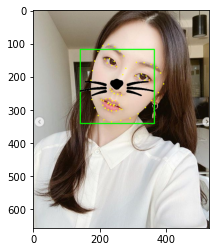

In [18]:
# 스티커에서 사용할 부분은 0이 아닌 색이 있는 부분 사용
# np.where통해 img_sticker가 0인 부분은 sticker_area를 사용
# 0이 아닌 부분을 img_sticker사용
img_show[refined_y:refined_y+ img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

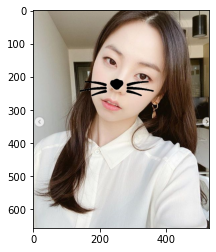

In [19]:
# bounding box와 landmark제거하고 최종 결과만 출력
# img_show 대신, img_rbg 활용
sticker_area = img_bgr[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

# 문제점 찾아보기
- 다양한 각도에서 셀카 촬영, 반복 적용
- 문제점이 뭔지 최대한 자세히 기록
    -얼굴 각도에 따라 스티커가 어떻게 변해야할까요?  
    
    -멀리서 촬영하면 왜 안될까요? 옆으로 누워서 촬영하면 왜 안될까요?
    
    -실행 속도가 중요할까요?
    
    -스티커앱을 만들 때 정확도가 얼마나 중요할까요?


# 고개를 옆으로 돌린 경우, 누운 경우

고개 각도에 따라서 스티커도 옆으로 회전시켜야할 것 같다. 아직 그 정도 단계는 아니라 어떻게 돌려야할 지는 모르겠다.